In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import numpy as np

import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()


In [6]:
ticker = 'WRAP'

In [7]:
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*5)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download(
    ticker, 
    start=start_date, 
    end=end_date, 
    progress=False
)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-29,5.00,5.00,5.00,5.00,5.00,100
2018-05-30,7.00,7.00,7.00,7.00,7.00,100
2018-05-31,7.24,7.24,7.24,7.24,7.24,100
2018-06-01,7.24,7.24,7.24,7.24,7.24,0
2018-06-04,8.00,8.00,8.00,8.00,8.00,100


In [8]:
# pd.DataFrame(data.index, data[])
df = data[['Adj Close', 'Volume']].reset_index()
df.rename(columns={'Adj Close': 'Adj_Close', 'Volume':'Adj_Volume'}, inplace=True)
df.head()

,Date,Adj_Close,Adj_Volume
0,2018-05-29,5.00,100
1,2018-05-30,7.00,100
2,2018-05-31,7.24,100
3,2018-06-01,7.24,0
4,2018-06-04,8.00,100


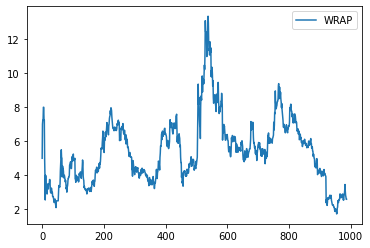

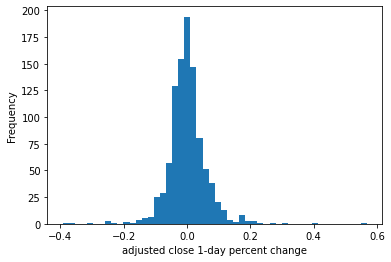

In [9]:
# Plot the Adj_Close columns
df['Adj_Close'].plot(label=ticker, legend=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for LNG
df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

                     5d_close_pct  5d_close_future_pct
5d_close_pct              1.00000             -0.01678
5d_close_future_pct      -0.01678              1.00000


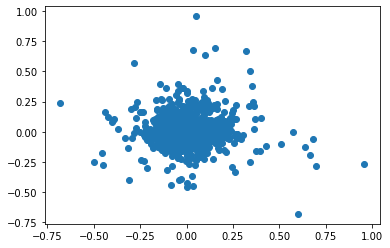

In [10]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
df['5d_future_close'] = df['Adj_Close'].shift(-5)
df['5d_close_future_pct'] = df['5d_future_close'].pct_change(5)
df['5d_close_pct'] = df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(df['5d_close_pct'], df['5d_close_future_pct'])
plt.show()

In [11]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    df['ma' + str(n)] = talib.SMA(df['Adj_Close'].values,
                              timeperiod=n) / df['Adj_Close']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [12]:
# Drop all na values
df = df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = df[feature_names]
targets = df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000     -0.064617  0.038251  0.013355   
5d_close_pct                   -0.064617      1.000000 -0.816384  0.672187   
ma14                            0.038251     -0.816384  1.000000 -0.831977   
rsi14                           0.013355      0.672187 -0.831977  1.000000   
ma30                           -0.010147     -0.632993  0.872799 -0.922754   
rsi30                           0.006878      0.505173 -0.660929  0.916361   
ma50                           -0.014808     -0.509803  0.727823 -0.891720   
rsi50                          -0.019679      0.401962 -0.544342  0.806724   
ma200                           0.089276     -0.210755  0.346586 -0.501809   
rsi200                         -0.086806      0.267719 -0.372542  0.594187   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct -0.010147  0.006878 -0.014808 -0.019679  0.08927

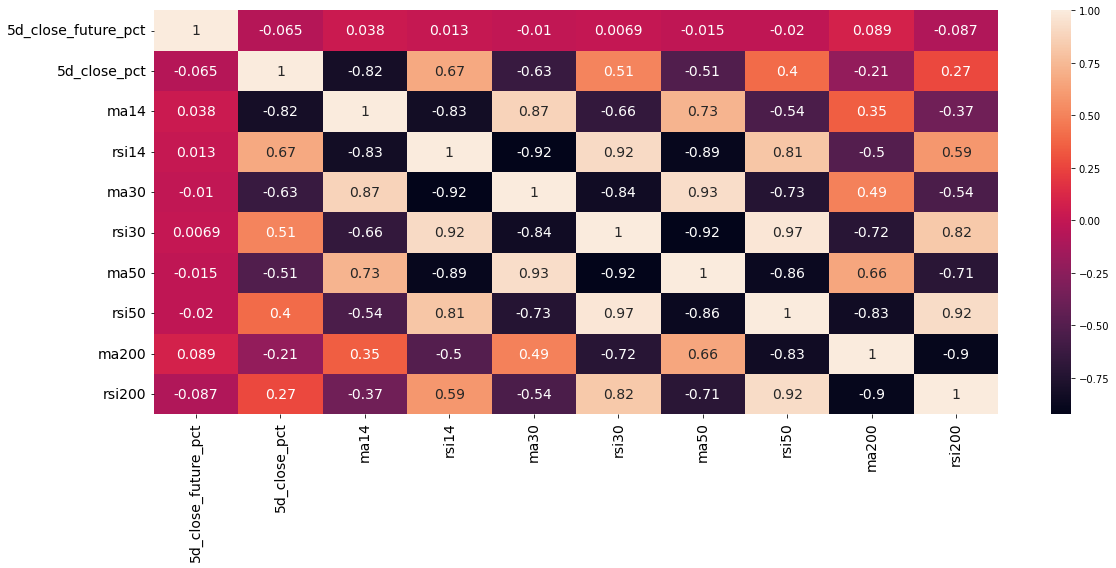

In [14]:
# Plot heatmap of correlation matrix
plt.figure(figsize = (17,8))
sns.heatmap(corr, annot= True, annot_kws = {"size": 14})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

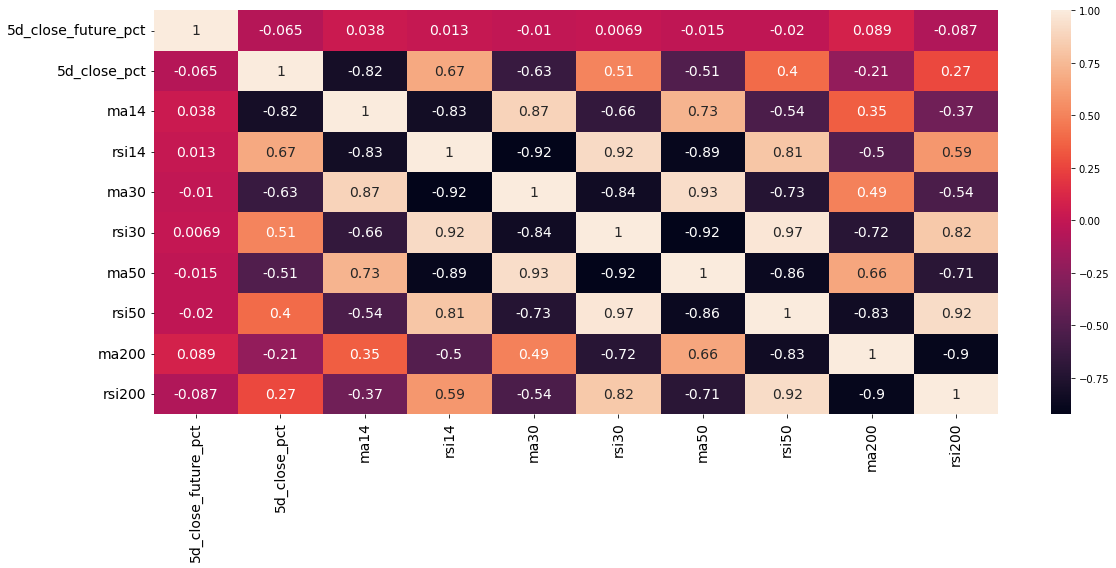

<Figure size 432x288 with 0 Axes>

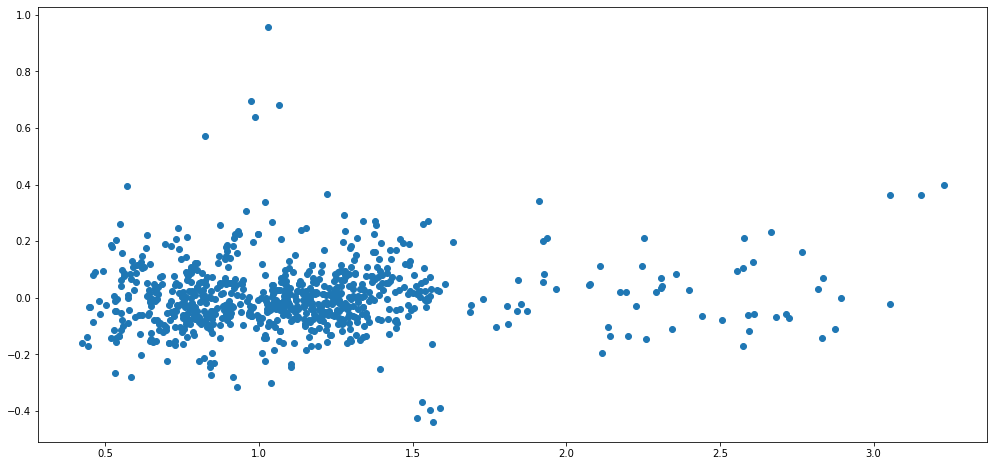

In [17]:
# Plot heatmap of correlation matrix
plt.figure(figsize = (17,8))
sns.heatmap(corr, annot=True, annot_kws = {"size": 14})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.figure(figsize = (17,8))
plt.scatter(df['ma200'], df['5d_close_future_pct'])
plt.show()

In [18]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(783, 10) (665, 10) (118, 10)


In [71]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  

# Update to keep only significant features
features = features[results.pvalues[results.pvalues < .05].index.values[1:]]
features.reset_index()
features.head()

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

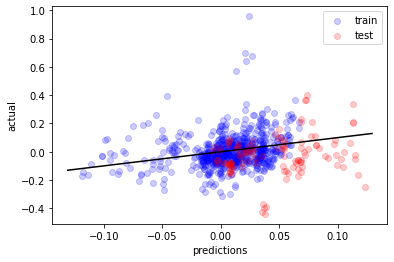

In [72]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha = .2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()